In [1]:
from IPython import display
%matplotlib inline
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf
import time
import torch

from torch import nn as nn
import torch.nn.functional as F

import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util

import tactile_gym.rl_envs
from tactile_gym.sb3_helpers.params import import_parameters

%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Make the pushing environment
algo_name = 'ppo'
env_name = 'object_push-v0'
rl_params, algo_params, augmentations = import_parameters(env_name, algo_name)
rl_params["env_modes"][ 'observation_mode'] = 'oracle_data'
print(rl_params)
print(algo_params)

env_kwargs={
    'show_gui':False,
    'show_tactile':False,
    'max_steps':rl_params["max_ep_len"],
    'image_size':rl_params["image_size"],
    'env_modes':rl_params["env_modes"],
}
env = gym.make(env_name, **env_kwargs)

seed = 0
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

{'algo_name': 'ppo', 'env_name': 'object_push-v0', 'max_ep_len': 1000, 'image_size': [128, 128], 'env_modes': {'movement_mode': 'TyRz', 'control_mode': 'TCP_velocity_control', 'rand_init_orn': False, 'rand_obj_mass': False, 'traj_type': 'simplex', 'observation_mode': 'oracle_data', 'reward_mode': 'dense'}, 'policy': 'MultiInputPolicy', 'seed': 1, 'n_stack': 1, 'total_timesteps': 1000000, 'n_eval_episodes': 10, 'n_envs': 10, 'eval_freq': 2000.0}
{'policy_kwargs': {'features_extractor_class': <class 'tactile_gym.sb3_helpers.custom.custom_torch_layers.CustomCombinedExtractor'>, 'features_extractor_kwargs': {'cnn_base': <class 'stable_baselines3.common.torch_layers.NatureCNN'>, 'cnn_output_dim': 256, 'mlp_extractor_net_arch': [64, 64]}, 'net_arch': [{'pi': [256, 256], 'vf': [256, 256]}], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>}, 'learning_rate': 0.0003, 'n_steps': 2048, 'batch_size': 64, 'n_epochs': 10, 'gamma': 0.95, 'gae_lambda': 0.9, 'clip_range': 0.2, 'clip_range_vf

pybullet build time: Mar  8 2021 17:26:24


ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu


In [3]:
trial_length = 1000
num_trials = 10
ensemble_size = 5

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "out_size": "???",
        "deterministic": False,
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
        "target_normalize": False
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 64,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

In [4]:
# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnvPushing(env, dynamics_model, termination_fn=None, reward_fn=None, generator=generator)

/home/qt21590/anaconda3/envs/tactile_gym_mbrl/lib/python3.9/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


In [5]:
print(dynamics_model.model.hidden_layers[0][0])
print(dynamics_model.model.hidden_layers[0][0].weight.shape)
print(dynamics_model.model.hidden_layers[0][0].bias.shape)

EnsembleLinearLayer(num_members=5, in_size=32, out_size=200, bias=True)
torch.Size([5, 32, 200])
torch.Size([5, 1, 200])


The weights are initialised using a truncated normal distribution. 

torch.Size([32000])


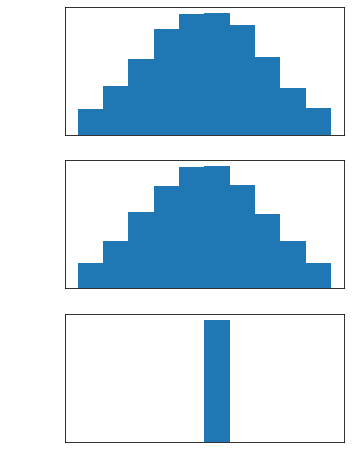

In [6]:
print(dynamics_model.model.hidden_layers[0][0].weight.flatten().shape)
plt.subplot(3, 1, 1)
plt.hist(dynamics_model.model.hidden_layers[0][0].weight.flatten().detach().numpy())
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.subplot(3, 1, 2)
plt.hist(dynamics_model.model.hidden_layers[1][0].weight.flatten().detach().numpy())
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.gcf().set_size_inches(5, 8)
plt.subplot(3, 1, 3)
plt.hist(dynamics_model.model.hidden_layers[1][0].bias.flatten().detach().numpy())
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.gcf().set_size_inches(5, 8)

plt.show()

Truncated normal intialisation reduces the size of the weights. Original weight initialisation has weights ranging from 0 to 1. Truncated means now it's in a smaller range. Produces smaller output. 

In [7]:
# Truncated weight initialisation
from mbrl.models.util import EnsembleLinearLayer
from mbrl.util.math import truncated_normal_
x = EnsembleLinearLayer(1, 2, 2)
print(x.weight.data)
num_members, input_dim, _ = x.weight.data.shape
stddev = 1 / (2 * np.sqrt(input_dim))
for i in range(1):
    truncated_normal_(x.weight.data[i], std=stddev)

print(x.weight)

tensor([[[0.7026, 0.4488],
         [0.4416, 0.3362]]])
Parameter containing:
tensor([[[-0.0361,  0.0671],
         [-0.6799, -0.2633]]], requires_grad=True)


In [8]:
agent_cfg = omegaconf.OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
    "planning_horizon": 15,
    "replan_freq": 1,
    "verbose": False,
    "action_lb": "???",
    "action_ub": "???",
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "mbrl.planning.CEMOptimizer",
        "num_iterations": 5,
        "elite_ratio": 0.1,
        "population_size": 500,
        "alpha": 0.1,
        "device": device,
        "lower_bound": "???",
        "upper_bound": "???",
        "return_mean_elites": True,
        "clipped_normal": False
    }
})

agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=20
)

In [9]:
def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())   # this returns val score per ensemble model

# samples stored 10000
Training time:  152.13474249839783
Train Loss: -46.77219219335774, Val Loss: 2.327242782484973e-06


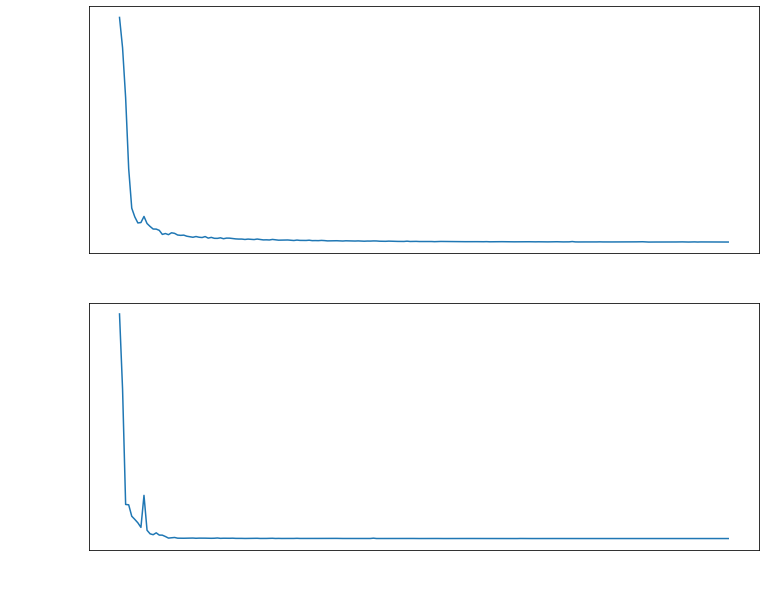

In [10]:
# Test optimisation iterations for CEM
train_losses = []
val_scores = []

# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnvPushing(env, dynamics_model, termination_fn=None, reward_fn=None, generator=generator)

replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)
common_util.rollout_agent_trajectories(
    env,
    10000, # initial exploration steps
    planning.RandomAgent(env),
    {}, # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length
)

print("# samples stored", replay_buffer.num_stored)

# Train model first
model_trainer = models.ModelTrainer(dynamics_model, optim_lr= 1e-3, weight_decay=5e-5)
dynamics_model.update_normalizer(replay_buffer.get_all())
dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
    replay_buffer,
    batch_size=cfg.overrides.model_batch_size,
    val_ratio=cfg.overrides.validation_ratio,
    ensemble_size=ensemble_size,
    shuffle_each_epoch=True,
    bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
)

start_train_time = time.time()
model_trainer.train(
    dataset_train, 
    dataset_val=dataset_val, 
    num_epochs=200, 
    patience=50, 
    callback=train_callback,
    silent=True)
train_time = time.time() - start_train_time

print("Training time: ", train_time)
print("Train Loss: {}, Val Loss: {}".format(train_losses[-1], val_scores[-1]))

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(train_losses)
ax[0].set_xlabel("Total training epochs")
ax[0].set_ylabel("Training loss (avg. NLL)")
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[1].plot(val_scores)
ax[1].set_xlabel("Total training epochs")
ax[1].set_ylabel("Validation score (avg. MSE)")
ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
plt.show()

In [11]:
# -------- Test model one set of action sequences from buffer to see exploding -------
# states still occur

# Get action sequence from buffer
data = replay_buffer.get_all()
action_sequences = data.act[0:15,:]
action_sequences = np.tile(action_sequences, (5,1,1)).astype(np.float32)
action_sequences = torch.from_numpy(action_sequences)
# print(action_sequences.shape)

# Initialise state and create model input
initial_state = data.obs[0]
# print(initial_state.shape)
initial_obs_batch = np.tile(initial_state, (5,1)).astype(np.float32)
# print(initial_obs_batch.shape)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)
# print(model_state['propagation_indices'])

batch_size = initial_obs_batch.shape[0]
total_rewards = torch.zeros(batch_size, 1)
terminated = torch.zeros(batch_size, 1, dtype=bool)
model_env.reset_batch_goals(batch_size)

print(data.obs[1][0:3])
print(data.next_obs[1][0:3])
print(data.act[1])

for time_step in range(15):
    print(torch.mean(model_state["obs"], 0)[0:3])
    # print(model_state["obs"].shape)
    # print(torch.mean(model_state["obs"]))
    action_for_step = action_sequences[:, time_step, :]
    # print(action_for_step[0])

    # Re-initialise model state from data buffer with every time step (1 step rollouts)
    # Comment out to do planning_horizon step rollouts
    # initial_state = data.obs[time_step]
    # initial_obs_batch = np.tile(initial_state, (5,1)).astype(np.float32)
    # initial_obs_batch = torch.from_numpy(initial_obs_batch)
    # model_state.update({'obs': initial_obs_batch})
    # action_batch = torch.repeat_interleave(
    #     action_for_step, 20, dim=0
    # )

    action_batch = action_for_step
    # ---------------- Use model_env.step -----------------
    # _, rewards, dones, model_state = model_env.step(
    #     action_batch, model_state, sample=True
    # )
    # rewards[terminated] = 0
    # terminated |= dones
    # total_rewards += rewards

    # -------------- Use one_dim_tr_model sample -------------
    # with torch.no_grad():
    #     next_observs, _, _, next_model_state, = model_env.dynamics_model.sample(
    #         action_batch, model_state, deterministic=False, rng=model_env._rng,
    #     )

    # -------------- Use model.sample_1d() --------------------
    # with torch.no_grad():
    #     obs = model_state["obs"]
    #     model_in = model_env.dynamics_model._get_model_input(model_state["obs"], action_batch)
    #     next_observs, _ = model_env.dynamics_model.model.sample_1d(
    #         model_in, model_state, rng=model_env._rng, deterministic=False
    #     )
    #     next_observs += obs
    #     model_state["obs"] = next_observs

    # -------------- Use model.forward()-------------------------
    with torch.no_grad():
        obs = model_state["obs"]
        model_in = model_env.dynamics_model._get_model_input(model_state["obs"], action_batch)
        means, logvars = model_env.dynamics_model.model.forward(
            model_in, rng=model_env._rng, propagation_indices=model_state["propagation_indices"]
        )
        variances = logvars.exp()
        stds = torch.sqrt(variances)
        # stds = torch.ones((5,30))
        next_observs = torch.normal(means, stds, generator=model_env._rng)
        # next_observs = means
        # print(torch.mean(means))
        # print(torch.mean(logvars))
        # print(torch.mean(stds))
        if dynamics_model.target_normalizer:
            next_observs = dynamics_model.target_normalizer.denormalize(next_observs)

        if dynamics_model.target_is_delta:
            next_observs += obs
        model_state["obs"] = next_observs

[0.000963 0.000743 -0.000006]
[0.001963 0.000462 -0.000008]
[0.082175 0.013591]
tensor([ 3.7849e-06,  5.6624e-06, -5.6028e-06])
tensor([-0.0046, -0.0043,  0.0026])
tensor([0.0086, 0.0095, 0.0114])
tensor([0.1137, 0.1918, 0.1113])
tensor([0.8701, 1.5817, 0.4094])
tensor([2.4128, 0.9166, 1.4810])
tensor([17.0331, 33.6370, 37.0832])
tensor([ 181.2846,  529.3672, -236.3672])
tensor([547.8633, 737.8794,  72.4002])
tensor([ 2860.4536,  7753.5352, 11212.6377])
tensor([ 55544.7930, 156902.2188, -43854.1953])
tensor([164099.8281, 188322.4219,  67250.3125])
tensor([ 945944.1250, 2276304.7500, 3227450.5000])
tensor([ 15347454.,  43706376., -14194770.])
tensor([45448792., 55257364., 17931574.])


Action selection for random agent is uniform distribution

In [22]:
print(model_state['obs'].shape)

torch.Size([5, 24])


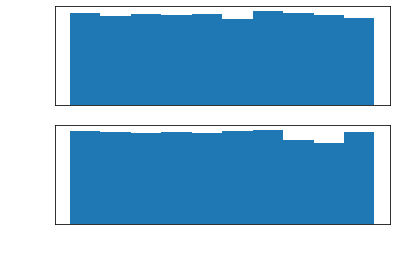

In [10]:
# Plot action distribution 
action_batch = np.zeros((10000,2))
for i in range(10000):
    action_batch[i,:] = env.action_space.sample()

plt.subplot(2, 1, 1)
plt.hist(action_batch[:, 0])
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.subplot(2, 1, 2)
plt.hist(action_batch[:, 1])
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

This plots the histogram for each feature of the input observation for the initial buffer. This distribution is not repressentative of the whole data if it's only one trial. If the input distribution follows a normal distribution, then standisation offers a pretty good input normaliser. When features are more-or-less uniformly distributed across a fixed length, then normalisation offers a pretty good normaliser (linear scaling between max and min). 

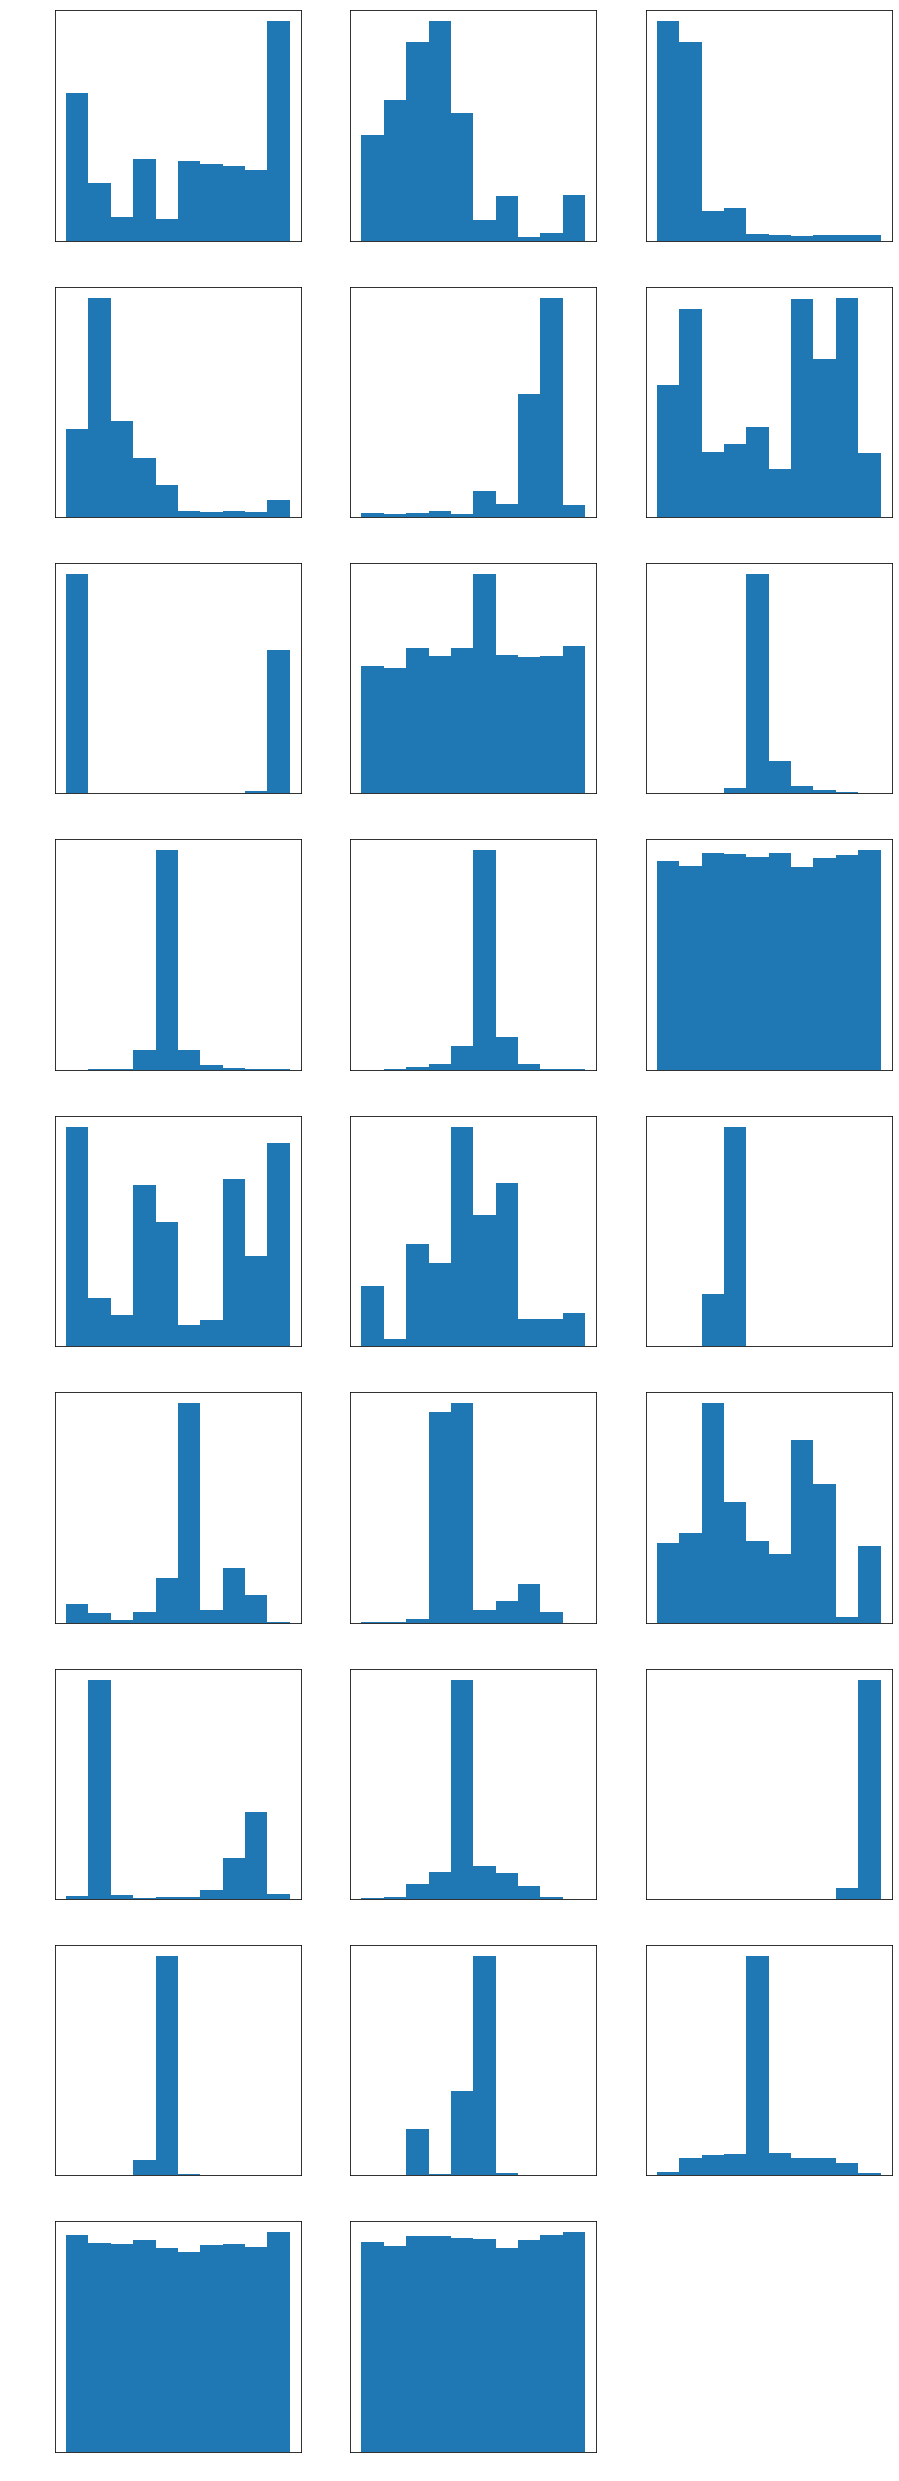

In [17]:
# Plot histogram for all the 26 features for input obs
batch = replay_buffer.get_all()
obs = batch.obs
act = batch.act
model_in = np.concatenate([obs, act], axis=obs.ndim - 1)

for i in range(1,27):
    plt.subplot(10, 3, i)
    plt.hist(model_in[:, i-1])
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')

plt.gcf().set_size_inches(15, 50)
plt.show()

(10000, 24)


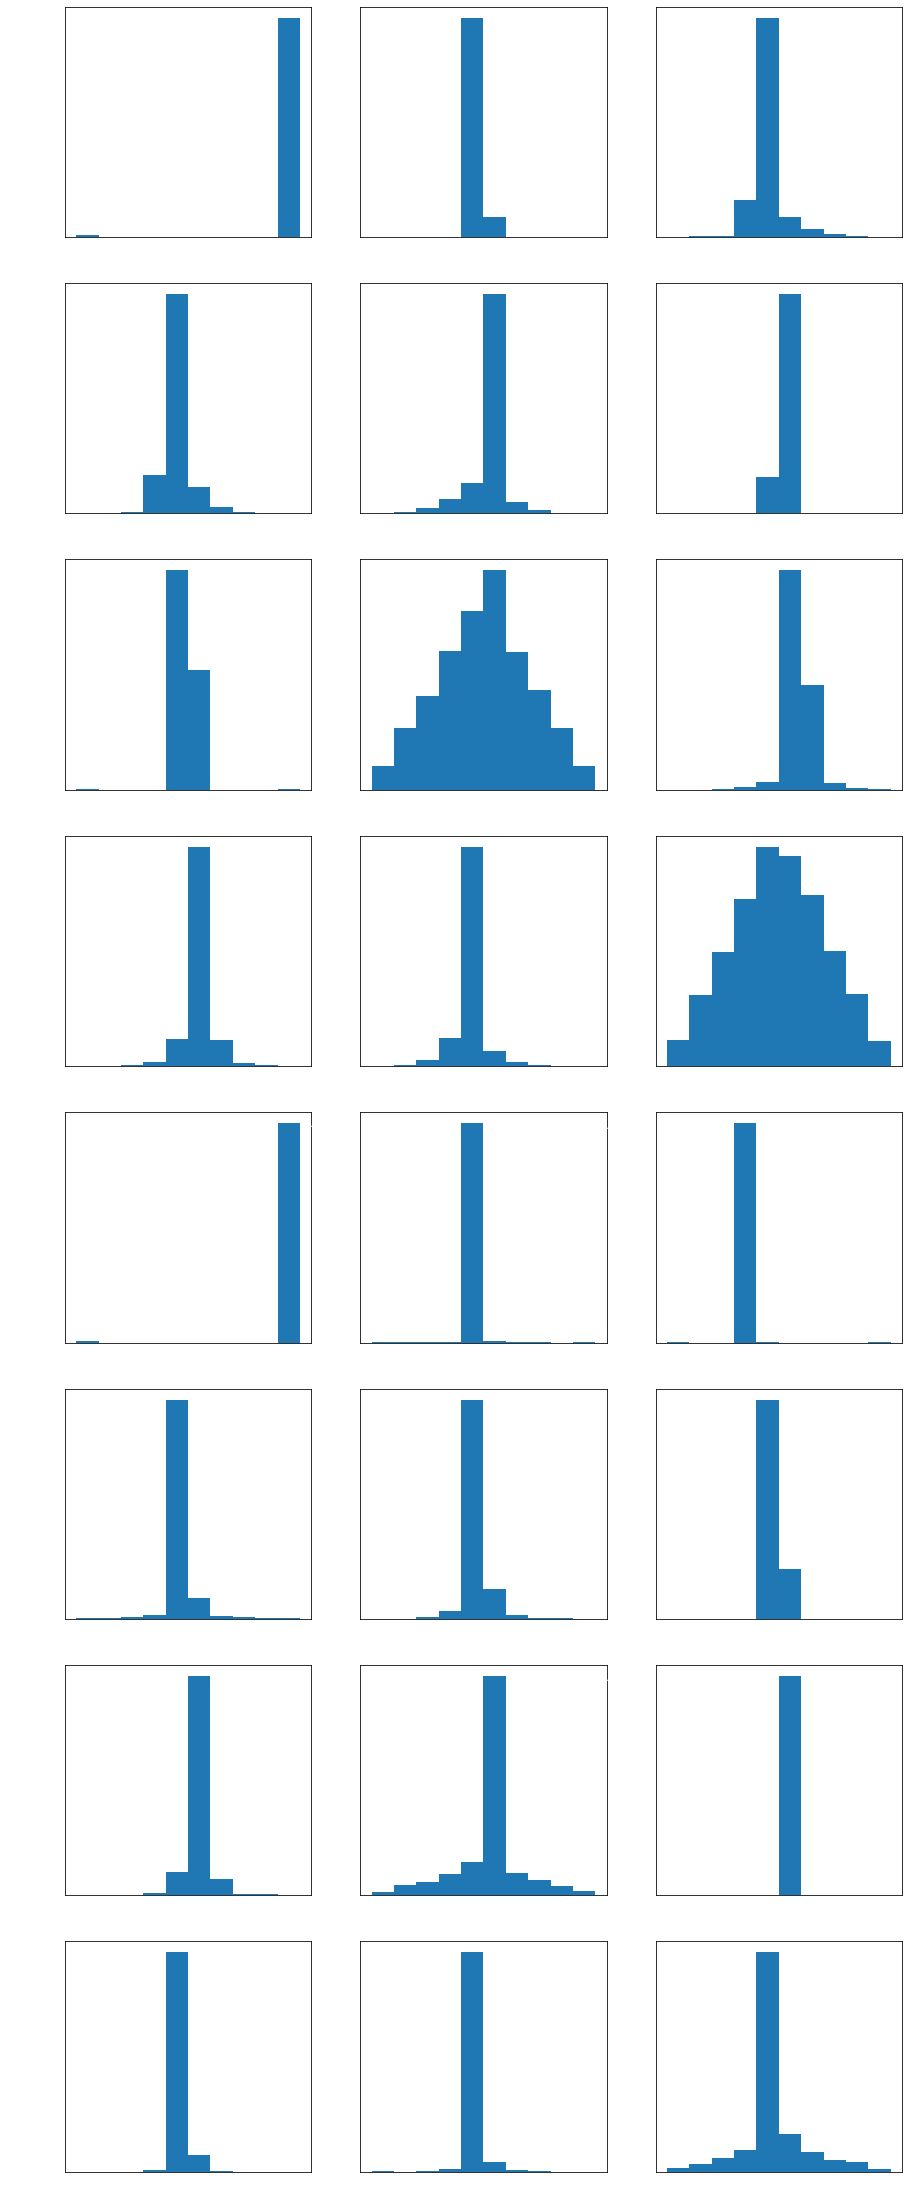

In [19]:
# Plot histogram for all the 24 features for target obs
batch = replay_buffer.get_all()
obs = batch.obs
next_obs = batch.next_obs
target = next_obs - obs
print(target.shape)

for i in range(1,25):
    plt.subplot(10, 3, i)
    plt.hist(target[:, i-1])
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')

plt.gcf().set_size_inches(15, 50)
plt.show()

Some features the stand deviation was too small so the std got set at 1, meaning it's original standard deviation stayed the same

In [61]:
# Check process batch is working correctly with target normalizer
batch = replay_buffer.get_all()
model_in, target = dynamics_model._process_batch(batch)
mean = target.mean(0, keepdim=True)
std = target.std(0, keepdim=True)
print(mean)
print(std)

tensor([[ 8.5831e-09,  2.0981e-08, -2.7285e-15, -3.1150e-14,  8.7311e-14,
         -5.7220e-09,  3.8147e-09, -1.2636e-08,  2.9104e-14, -2.1458e-09,
          0.0000e+00, -2.8610e-08, -7.6294e-09, -4.7684e-09, -1.5461e-14,
         -1.8190e-14,  3.2742e-14, -7.1526e-09,  2.8610e-09, -2.8610e-09,
          4.7684e-10, -1.9073e-09,  3.8147e-09,  9.5367e-10]])
tensor([[1.0000e+00, 1.0000e+00, 5.5488e-07, 2.1321e-06, 3.2666e-06, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 6.9677e-06, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.2225e-06, 2.9759e-06, 4.5056e-06, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]])


In [21]:
# Normalise the target
batch = replay_buffer.get_all()
obs = batch.obs
next_obs = batch.next_obs
target = next_obs - obs

target_obs = torch.from_numpy(target)
mean = target_obs.mean(0, keepdim=True)
std = target_obs.std(0, keepdim=True)
print(mean)
print(std)

# dynamics_model.update_normalizer(batch)
print(dynamics_model.target_normalizer.mean)
print(dynamics_model.target_normalizer.std)

# target_obs_normalised = (target_obs - mean) / std
# mean_normalised = target_obs_normalised.mean(0, keepdim=True)
# std_normalised = target_obs_normalised.std(0, keepdim=True)
# print(mean_normalised)
# print(std_normalised)

tensor([[ 2.5721e-04, -2.6640e-05,  2.7325e-07,  5.1042e-07, -4.2061e-07,
          3.8001e-04,  9.4752e-06, -8.0300e-06,  1.8502e-09,  2.3714e-09,
         -3.4226e-10, -3.0695e-05,  2.4239e-04,  3.2976e-05,  2.1927e-08,
         -6.0494e-08, -9.9961e-09,  1.2424e-03,  1.0648e-05, -8.3842e-07,
          8.7433e-10, -1.3609e-08, -1.1914e-08,  7.7647e-05]])
tensor([[2.6077e-03, 8.9181e-04, 9.4879e-07, 4.0427e-06, 4.9336e-06, 9.2842e-03,
         7.5130e-04, 8.3024e-03, 1.1225e-05, 4.7994e-05, 6.1111e-05, 7.0155e-02,
         2.6068e-03, 7.4477e-04, 1.7604e-06, 1.3328e-05, 9.5442e-06, 9.5340e-03,
         1.2450e-03, 3.3685e-03, 2.9735e-05, 1.5468e-04, 1.5998e-04, 7.3358e-02]])
tensor([[ 2.5721e-04, -2.6640e-05,  2.7325e-07,  5.1042e-07, -4.2061e-07,
          3.8001e-04,  9.4752e-06, -8.0300e-06,  1.8502e-09,  2.3714e-09,
         -3.4226e-10, -3.0695e-05,  2.4239e-04,  3.2976e-05,  2.1927e-08,
         -6.0494e-08, -9.9961e-09,  1.2424e-03,  1.0648e-05, -8.3842e-07,
          8.7433e-1

In [10]:
# print(dynamics_model.model.max_logvar)
# print(dynamics_model.model.min_logvar)
print(dynamics_model.input_normalizer.mean)
print(dynamics_model.input_normalizer.std)
print(dynamics_model.target_normalizer.mean)
print(dynamics_model.target_normalizer.std)

tensor([[ 4.2739e-02, -2.8541e-02,  5.3220e-05,  1.1922e-04,  7.1289e-05,
         -2.0917e-01,  5.4611e-03,  5.0464e-05,  3.0043e-06,  6.0043e-06,
          5.8404e-06,  7.4389e-04,  6.3482e-02,  4.2560e-03,  1.0746e-05,
         -1.2234e-05,  6.0864e-06,  3.0295e-01,  5.2751e-03,  8.6207e-04,
         -8.9972e-07, -5.0879e-06, -4.5872e-07,  1.3578e-02,  9.3430e-04,
          1.6980e-03]])
tensor([[9.4556e-02, 1.6188e-02, 8.3080e-05, 3.2038e-04, 1.4551e-04, 2.0941e-01,
         4.9119e-03, 5.6368e-03, 1.0449e-05, 4.3531e-05, 5.8729e-05, 5.0532e-02,
         8.0750e-02, 2.4650e-02, 1.0000e+00, 2.3144e-05, 1.8537e-05, 3.2085e-01,
         4.8289e-03, 2.8319e-03, 2.2381e-05, 1.1180e-04, 1.2206e-04, 5.1619e-02,
         1.4105e-01, 1.4510e-01]])
tensor([[ 2.7331e-04, -5.9214e-06,  1.6924e-07,  3.9181e-07,  2.9070e-07,
          6.1503e-04,  9.7776e-06, -9.1496e-06,  1.8340e-09,  7.4274e-08,
          7.7849e-08, -1.5758e-04,  2.3386e-04,  7.2702e-05,  2.1029e-08,
         -7.3422e-09, -2.

In [57]:
# Get batch of data from val data and calculate the loss
dataset_val.__iter__()
batch = dataset_val.__next__()

# Process batch function
obs, action, next_obs, reward, _ = batch.astuple()
model_in = model_trainer.model._get_model_input(obs, action)
target = next_obs - obs
target = torch.from_numpy(target)

pred_mean, pred_logvar = dynamics_model.model._default_forward(model_in, use_propagation=False)
target_obs = target.repeat((5, 1, 1))
# target_obs = (target_obs - mean) / std                  # normalising targets

print(pred_mean[0,0])
print(pred_logvar[0,0])
print(target_obs[0,0])
# print(obs[0,0])
# print(next_obs[0,0])

l2 = F.mse_loss(pred_mean, target_obs, reduction="none")
inv_var = (-pred_logvar).exp()
first_term_loss = l2*inv_var
second_term_loss = pred_logvar

# print(l2[0][0])
# print(inv_var[0][0])
# print(first_term_loss[0][0])
# print(second_term_loss[0][0])

# nll = util.math.gaussian_nll(pred_mean, pred_logvar, target_obs, reduce=False)
# print(nll[0,0])

print(l2.mean((1, 2)).sum())
print(inv_var.mean((1, 2)).sum())
print(first_term_loss.mean((1, 2)).sum())
print(second_term_loss.mean((1, 2)).sum())

nll = (util.math.gaussian_nll(pred_mean, pred_logvar, target_obs, reduce=False)
.mean((1, 2))
.sum())
print(nll)

# print(0.01 * (dynamics_model.model.max_logvar.sum() - dynamics_model.model.min_logvar.sum()))
# print(dynamics_model.model._nll_loss(model_in, target))

tensor([ 0.0016,  0.0012,  0.0008,  0.0014,  0.0008,  0.0004,  0.0008,  0.0110,
        -0.0003,  0.0004, -0.0007, -0.1092, -0.0008, -0.0011,  0.0007, -0.0004,
         0.0024,  0.0078, -0.0030,  0.0010,  0.0002, -0.0003,  0.0009, -0.0504],
       grad_fn=<SelectBackward0>)
tensor([-9.9913, -9.9968, -9.9939, -9.9940, -9.9951, -9.9896, -9.9972, -9.9941,
        -9.9969, -9.9934, -9.9947, -9.9620, -9.9975, -9.9973, -9.9951, -9.9951,
        -9.9930, -9.9903, -9.9956, -9.9962, -9.9967, -9.9940, -9.9946, -9.1720],
       grad_fn=<SelectBackward0>)
tensor([ 9.9840e-04, -1.2237e-04, -3.3528e-07, -8.2378e-07,  2.8692e-06,
        -7.8501e-03,  1.1442e-05,  5.7096e-03, -4.9274e-06,  2.0507e-05,
         3.9006e-05, -1.0987e-01,  1.0688e-03, -8.2254e-06, -1.9372e-07,
        -7.6999e-07, -5.8490e-06,  2.0785e-03,  8.5845e-04,  3.0435e-03,
        -2.0518e-06, -5.6143e-06, -6.5749e-05, -6.8677e-02])
tensor(4.7360e-05, grad_fn=<SumBackward0>)
tensor(104200.0938, grad_fn=<SumBackward0>)
tensor(0.4

In [13]:
# -------------Test trained model for a batch of initial action sequences ------------------------
# Create a batch of actions from action space limits
action_lb = env.action_space.low.tolist()
action_ub = env.action_space.high.tolist()
initial_solution = (((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
            .float()
        )
initial_solution = initial_solution.repeat((15, 1))

mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
action_sequences = torch.zeros((500,) + initial_solution.shape)
action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)

# Initialise states
initial_state = env.reset()
tiling_shape = (20 * 500,) + tuple(
    [1] * initial_state.ndim
)
initial_obs_batch = np.tile(initial_state, tiling_shape).astype(np.float32)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)
batch_size = initial_obs_batch.shape[0]
total_rewards = torch.zeros(batch_size, 1)
terminated = torch.zeros(batch_size, 1, dtype=bool)
model_env.reset_batch_goals(batch_size)

print(initial_obs_batch.shape)

for time_step in range(15):
    print(torch.mean(model_state["obs"], 0)[0:3])
    action_for_step = action_sequences[:, time_step, :]
    action_batch = torch.repeat_interleave(
        action_for_step, 20, dim=0
    )
    _, rewards, dones, model_state = model_env.step(
        action_batch, model_state, sample=True
    )
    rewards[terminated] = 0
    terminated |= dones
    total_rewards += rewards
    
# evaluate sequences
# print(model_env.evaluate_action_sequences(action_sequences, initial_state, 20).shape)

(10000, 24)
tensor([-8.9996e-02, -3.8594e-04, -5.6028e-06])
tensor([-0.0890, -0.0001,  0.0004])
tensor([-0.2108, -0.1576, -0.0887])
tensor([-2.7937, -5.2541, -2.3082])
tensor([ -77.4136, -166.8713,  -67.9918])
tensor([-2296.4319, -5212.6826, -2164.4746])
tensor([ -70131.4062, -163132.2969,  -69146.1406])
tensor([-2188091.5000, -5122007.0000, -2216076.0000])
tensor([-6.9249e+07, -1.6140e+08, -7.1118e+07])
tensor([-2.2118e+09, -5.1025e+09, -2.2838e+09])
tensor([-7.1052e+10, -1.6178e+11, -7.3372e+10])
tensor([-2.2901e+12, -5.1419e+12, -2.3579e+12])
tensor([-7.3951e+13, -1.6376e+14, -7.5795e+13])
tensor([-2.3902e+15, -5.2247e+15, -2.4370e+15])
tensor([-7.7278e+16, -1.6693e+17, -7.8369e+16])
